In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
!ls ../input

In [ ]:
import torch
from torch import nn
from torchvision import datasets, models, transforms


In [ ]:
import torch.utils.data as tdata

In [ ]:
!ls ../input/seg_train/seg_train/
!ls ../input/seg_test/seg_test/

In [ ]:
data_path_format = '../input/seg_{0}/seg_{0}'

In [ ]:
np.random.seed(5315)
torch.manual_seed(9784)

In [ ]:
# channel_means = (0.4301, 0.4572, 0.4540)
# channel_stds = (0.2698, 0.2680, 0.2983)  # 0.485, 0.456, 0.406
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])
    

In [ ]:
image_datasets = dict(zip(('dev', 'test'), [datasets.ImageFolder(data_path_format.format(key),transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

In [ ]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [ ]:
from sklearn import model_selection

In [ ]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [ ]:
print(len(val_indices))

In [ ]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [ ]:
print(image_datasets)

In [ ]:
from IPython.display import display

In [ ]:
image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}

In [ ]:
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [ ]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W  # H x W x C
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot('111')
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)  

In [ ]:
imshow(image_datasets['train'][8555][0]) # 5946

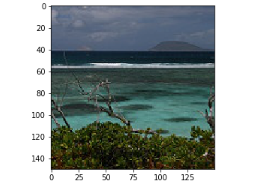

In [ ]:
cuda_device = torch.device('cuda')
cpu_device = torch.device('cpu')
device = cuda_device

In [ ]:
class doliNet(torch.nn.Module):
    def __init__(self):
        super(doliNet, self).__init__()
        
        self.block0 = nn.Sequential(torch.nn.BatchNorm2d(3))
        
        self.block1 = nn.Sequential(torch.nn.Conv2d(3, 16, 3, padding=1),
                                    torch.nn.ReLU(),
                                    torch.nn.BatchNorm2d(16),
                                    torch.nn.MaxPool2d(2, 2))
        
        self.block2 = nn.Sequential(torch.nn.Conv2d(16, 32, 3, padding=1),
                                    torch.nn.ReLU(),
                                    torch.nn.BatchNorm2d(32),
                                    torch.nn.MaxPool2d(2, 2))
        
        self.block3 = nn.Sequential(torch.nn.Conv2d(32, 64, 3, padding=1),
                                    torch.nn.ReLU(),
                                    torch.nn.BatchNorm2d(64),
                                    torch.nn.MaxPool2d(2, 2))
        
        self.block4 = nn.Sequential(torch.nn.Conv2d(64, 128, 3, padding=1),
                                    torch.nn.ReLU(),
                                    torch.nn.BatchNorm2d(128),
                                    torch.nn.MaxPool2d(2, 2))
        
        self.block5 = nn.Sequential(torch.nn.Conv2d(128, 256, 3, padding=1),
                                    torch.nn.ReLU(),
                                    torch.nn.BatchNorm2d(256),
                                    torch.nn.MaxPool2d(2, 2))
        
        self.block6 = nn.Sequential(torch.nn.Conv2d(256, 512, 3, padding=1),
                                    torch.nn.ReLU(),
                                    torch.nn.BatchNorm2d(512))
        
        self.block7 = nn.Sequential(torch.nn.Linear(8192, 256),
                                    torch.nn.Tanh(),
                                    torch.nn.BatchNorm1d(256))
        
        self.block8 = nn.Sequential(torch.nn.Linear(256, 64),
                                    torch.nn.Tanh(),
                                    torch.nn.BatchNorm1d(64))
        
        self.block9 = nn.Sequential(torch.nn.Linear(64, 6))
        
        
        self.conv_blocks = nn.Sequential(self.block0,self.block1,self.block2,self.block3,self.block4,self.block5,self.block6)
        self.linear_blocks = nn.Sequential(self.block7,self.block8,self.block9)
    
    
    def forward(self, x):
        
        x = self.conv_blocks(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.linear_blocks(x)
        
        return x

In [ ]:
ptr = doliNet()
ptr = ptr.to(device)

In [ ]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [ ]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)
                
                
            
        

In [ ]:
import time
start = time.time()

In [ ]:
optimizer = torch.optim.Adam(ptr.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(20, ptr, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

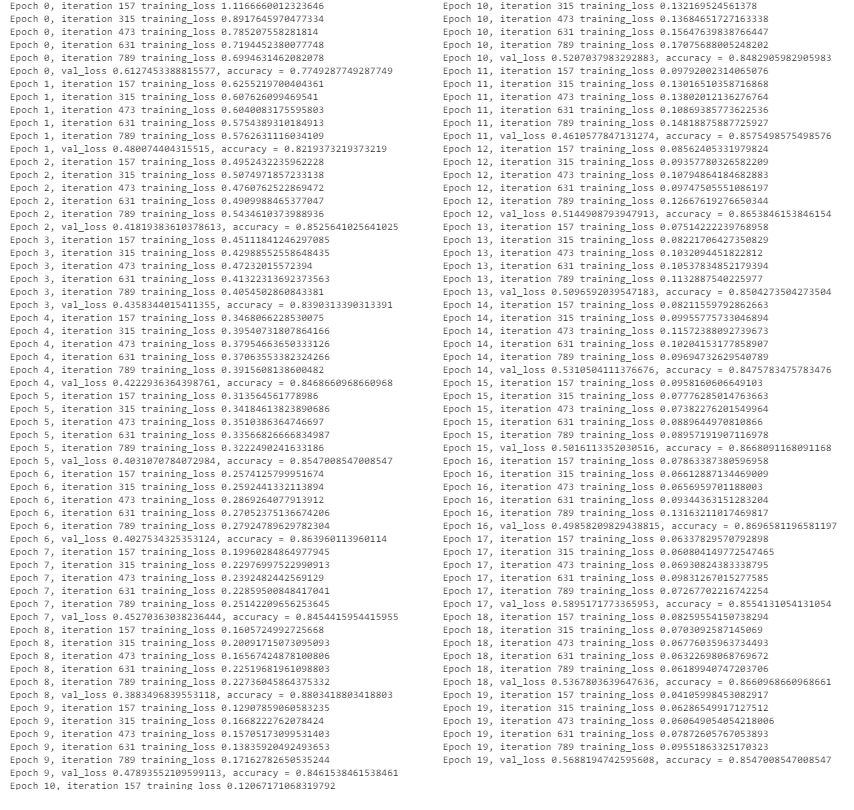

In [ ]:
end = time.time()
print(end - start)

In [ ]:
from torchvision.utils import make_grid

In [ ]:
xx, yy = next(iter(image_dataloaders['validation']))

In [ ]:
ptr.eval()
out = ptr(xx.cuda())
preds = out.argmax(1)
predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
actual_classes = [image_datasets['dev'].classes[c] for c in yy]
imshow(make_grid(xx, nrow=4), fig_size=(8,8))
print(predicted_classes)
print(actual_classes)

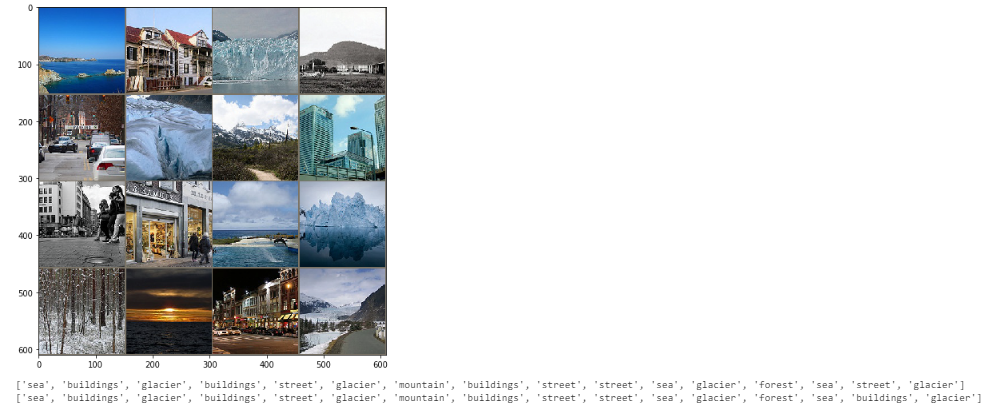

In [ ]:
all_preds = []
correct_preds = []
with torch.no_grad():
    ptr.eval()
    for xx, yy in image_dataloaders['test']:
        xx = xx.to(device)
        output = ptr(xx)
        all_preds.extend(output.argmax(1).tolist())
        correct_preds.extend(yy.tolist())

In [ ]:
from sklearn import metrics

In [ ]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [ ]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

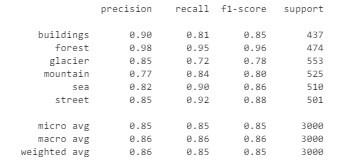

In [ ]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

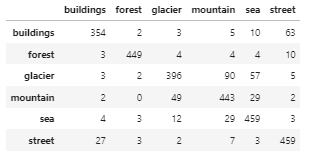